In [468]:
#! pip install --user tslearn matplotlib

import os
## TODO change to 0
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

import random
import numpy
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

from src.learning_shapelets import LearningShapelets

In [470]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

In [471]:
dataset = "FaceFour"
# Load training data
X_train = numpy.load(open(os.path.join('data', f'{dataset}_train.npy'), 'rb'))
X_train_size = X_train.shape[0]
print(f"Shape X_train: {X_train.shape}")
# load trainng data labels
y_train = numpy.load(open(os.path.join('data', f'{dataset}_train_labels.npy'), 'rb'))
# normalize training data
X_train, scaler = normalize_data(X_train)

OSError: [Errno 22] Invalid argument: 'data\\FaceFour_train.npy'

In [454]:
n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 48 shapelets
shapelets_size_and_len = {120: 8}
dist_measure = "euclidean"
lr = 4e-3
wd = 1e-4
epsilon = 1e-7
batch_size = 256
shuffle = True
drop_last = False


In [455]:
shapelets_blocks = []
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    shapelets_blocks.append(weights_block)

In [456]:
l1 = 0.1
l2 = 0.01
k = int(0.1 * batch_size) if batch_size <= X_train_size else X_train_size


learning_shapelets_Lr = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure,
                                       l1=l1,
                                       l2=l2,
                                       k=k)

In [457]:
for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets_Lr.set_shapelet_weights_of_block(i, shapelets_block)

In [458]:
optimizer = optim.Adam(learning_shapelets_Lr.model.parameters(), lr=lr, eps=epsilon)
learning_shapelets_Lr.set_optimizer(optimizer)

In [459]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
        print(predictions)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    return (predictions == Y).sum() / Y.size

In [460]:
epochs = 200
n_epoch_steps = 1
losses = []
train_acc_last = 0

losses_acc = []
losses_dist = []
losses_sim = []
train_acc_last_Lr = 0
for _ in range(n_epoch_steps):
    losses_acc_i, losses_dist_i, losses_sim_i = \
        learning_shapelets_Lr.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=drop_last)
    losses_acc += losses_acc_i

    losses_dist += losses_dist_i
    losses_sim += losses_sim_i
    train_acc_current_Lr = eval_accuracy(learning_shapelets_Lr, X_train, y_train)
    if train_acc_current_Lr - train_acc_last_Lr < 1e-3 or train_acc_current_Lr == 1.0:
        break
    train_acc_last_Lr = train_acc_current_Lr

Loss CE: 0.16646118462085724, Loss dist: 0.5829148888587952, Loss sim: 0.0005110746715217829: 100%|██████████████| 200/200 [00:03<00:00, 53.69it/s]


[1 1 0 0 1 3 3 3 0 0 3 1 0 1 2 1 2 1 2 0 3 0 1 0]
Accuracy: 1.0


In [465]:
# Load data set
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)
test_acc = eval_accuracy(learning_shapelets_Lr, X_test, y_test)
print(test_acc)

OSError: [Errno 22] Invalid argument: 'data\\FaceFour_test.npy'

In [175]:
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)

Shape X_train: (88, 1, 350)


In [469]:
save_shapelets = learning_shapelets_Lr.get_shapelets()
numpy.save('shapelets_Lr_8_FF.npy', save_shapelets)
shapelets_Lr = numpy.load("shapelets_Lr_8_FF.npy")
n_shapelets_Lr = shapelets_Lr.shape[0]
n_shapelets = shapelets_Lr.shape[0]

OSError: [Errno 22] Invalid argument: 'shapelets_Lr_8_FF.npy'

# ANALYSIS

In [119]:
def filterNanFromShapelet(shapelet):
    """
    Filter NaN values from a shapelet.
    Needed for the output of learning shapelets from tslearn, since smaller size shapelets are padded with NaN values.
    Note: Make sure the NaN values are only leading or trailing.
    """
    return shapelet[~numpy.isnan(shapelet)]

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, filterNanFromShapelet(shapelet)])
    return padded_shapelet

def torch_dist_ts_shapelet(ts, shapelet, to_cuda=True):
    """
    Use PyTorch to calculate the distance between a shapelet and a time series.
    Implemented via unfolding.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if to_cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    if shapelet.dim() == 1:
        shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[1], 1)
    # calculate euclidean distance over each segment
    dists = torch.sum(torch.cdist(ts, shapelet, p=2), dim=0)
    # filter min dist
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def dists_to_shapelet(data, shapelet, to_cuda=True):
    """
    Calculate the distances of a shapelet to a bunch of time series.
    """
    shapelet = filterNanFromShapelet(shapelet)
    dists = []
    for i in range(len(data)):
        dists.append((torch_dist_ts_shapelet(data[i,:], shapelet, to_cuda=to_cuda), i))
    return sorted(dists, key=lambda x: x[0][0])



def plot_shapelet_on_ts_at_i(shapelet, ts, i, title="", axis=None):
    """
    Plot a shapelet on top of a timeseries
    """
    shapelet = filterNanFromShapelet(shapelet)
    padded_shapelet = lead_pad_shapelet(shapelet, i)
    if axis is None:
        pyplot.clf()
        pyplot.rcParams["figure.figsize"] = (23, 6)
        pyplot.plot(ts)
        pyplot.plot(padded_shapelet)
    else:
        axis.plot(ts)
        axis.plot(padded_shapelet)
        
#CUSTOM:

def dists_ts_to_shapelets(ts, shapelets, to_cuda=False):
    """
    Calculate the distances of shapelets to a timeseries
    """
    dists = []
    for i in range(len(shapelets)):
        shapelet = filterNanFromShapelet(shapelets[i])
        dists.append((torch_dist_ts_shapelet(ts, shapelet, to_cuda=to_cuda),i))
    return sorted(dists, key=lambda x: x[0][0])

def plot_ts_and_shapelet(ts,shapelet): 
    sh = filterNanFromShapelet(shapelet)
    dist, pos = torch_dist_ts_shapelet(ts,sh,to_cuda=False)
    padded_shapelet = lead_pad_shapelet(sh,pos)
    pyplot.plot(ts.flatten())
    pyplot.plot(padded_shapelet)
    pyplot.show()


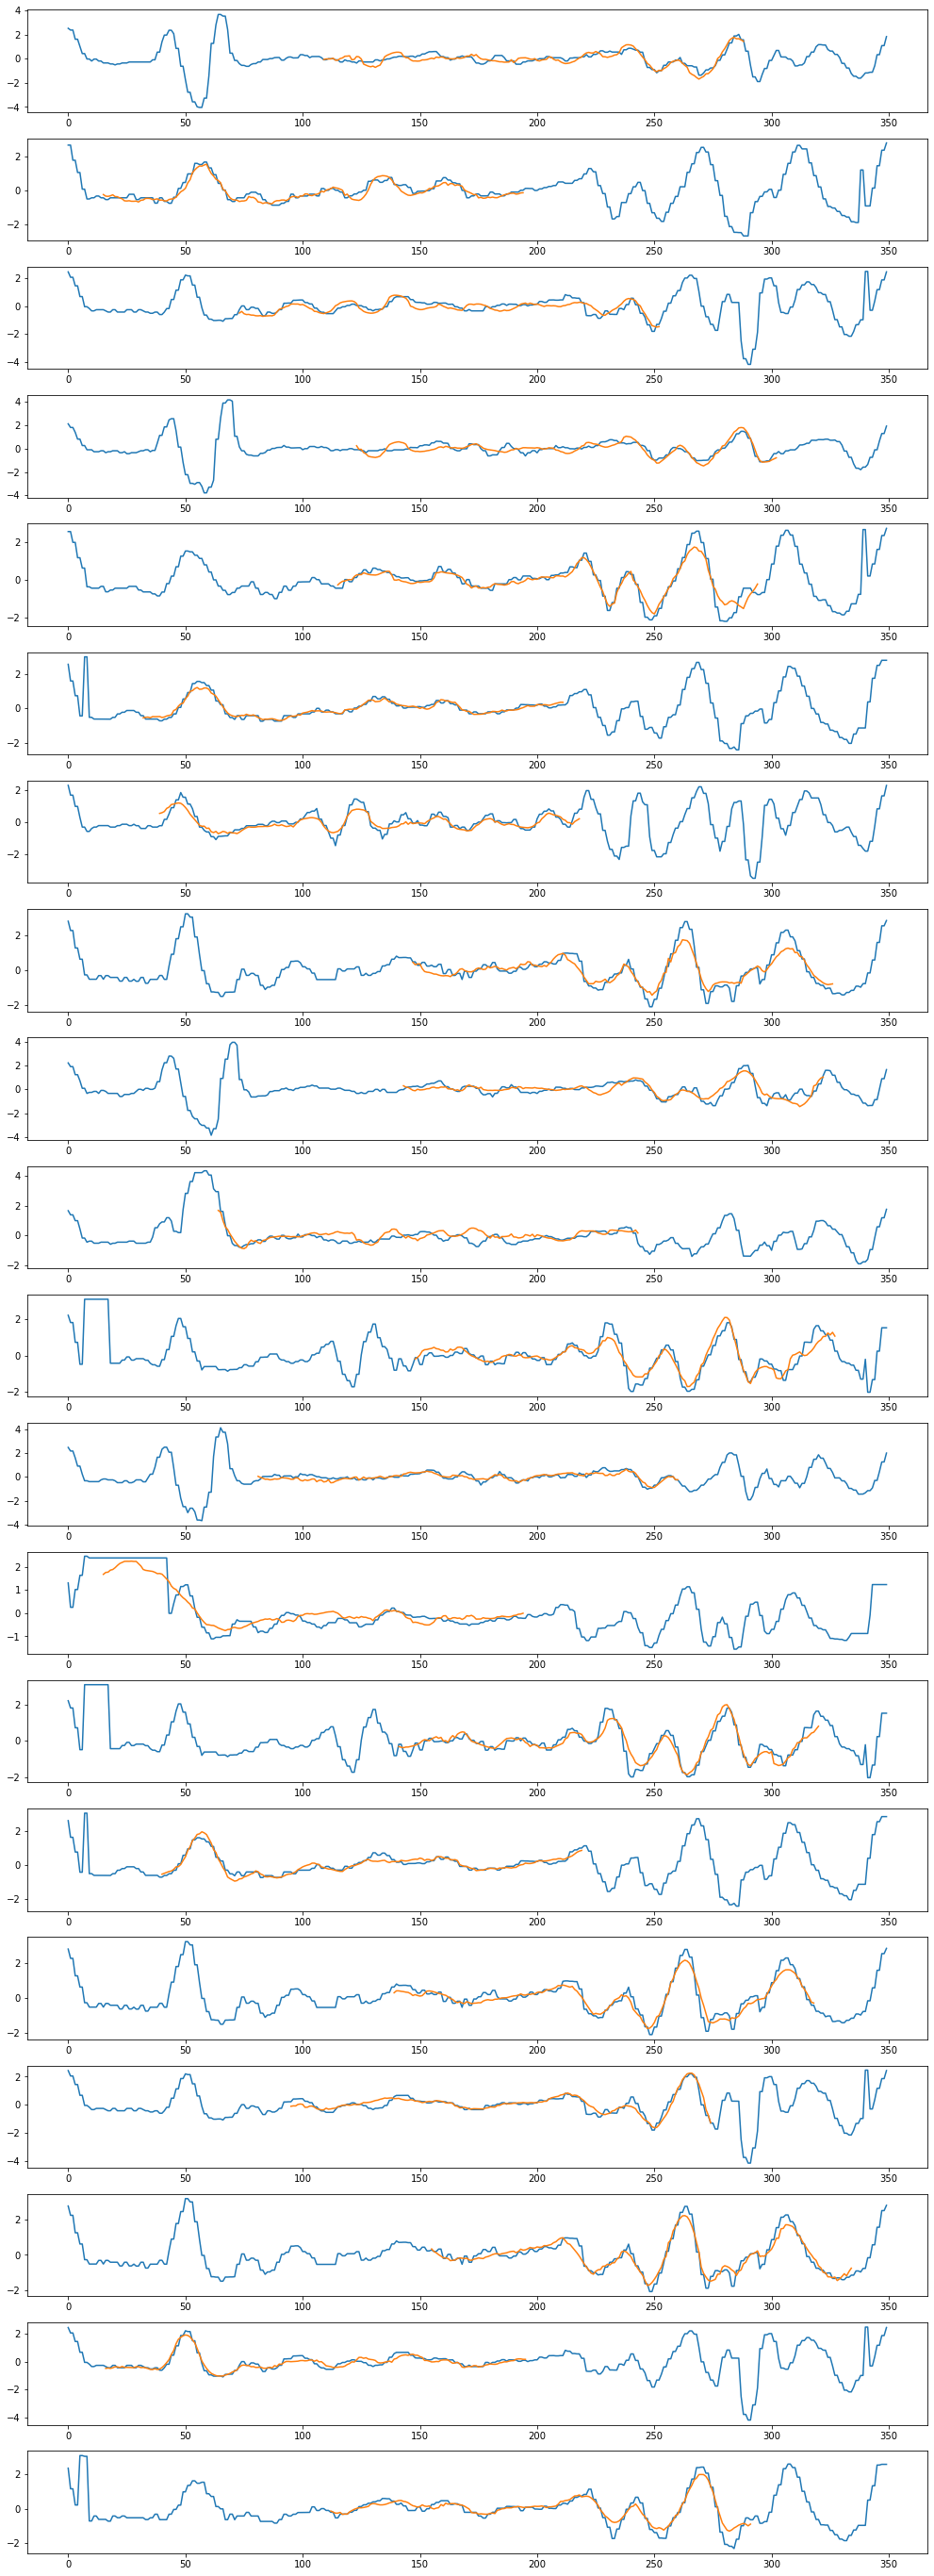

In [302]:
fig, axes = pyplot.subplots(n_shapelets, 1)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
#fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

relative_distances_gra = []
relative_distances_contrastive = []
for i in range(n_shapelets):
    if i < n_shapelets_Lr:
        shapelet_Lr = filterNanFromShapelet(shapelets_Lr[i, 0])
        best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=False)[0]
        plot_shapelet_on_ts_at_i(shapelet_Lr, X_test[best_match_Lr[1], 0], best_match_Lr[0][1], axis=axes[i])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()

In [179]:
import numpy as np
import pandas as pd

def find_ts_per_class(y_test, searched_class): 
    normal_sort = np.sort(y_test)
    arg_sort = np.argsort(y_test)
    class_x = arg_sort[np.where(normal_sort==searched_class)]
    return class_x

def get_best_explanations_per_class(number,y):
    normal_sort = np.sort(y)
    arg_sort = np.argsort(y)
    #For each class
    explanations_per_class = dict()
    for i in set(y):
        explanations_per_class[i] = list()
        ts_per_class = arg_sort[np.where(normal_sort==i)]
        for ts in ts_per_class: 
            explanations = dists_ts_to_shapelets(X_test[ts],shapelets_Lr)[:number]
            explanations_per_class[i].append(*explanations) #[for single values *explnations]
    return explanations_per_class

best_exp = get_best_explanations_per_class(1,y_test)

In [424]:
def get_stats_for_explanations_per_class(X,y):
    normal_sort = np.sort(y)
    arg_sort = np.argsort(y)
    #For each class
    explanations_per_class = dict()
    for i in set(y):
        explanations_per_class[i] = list()
        ts_per_class = arg_sort[np.where(normal_sort==i)]
        for ts in ts_per_class: 
            explanations = dists_ts_to_shapelets(X[ts],shapelets_Lr)
            sort_by_shapeletnr = [(x[0][0]) for x in sorted(explanations, key = lambda x: x[1])]
            #print(sort_by_shapeletnr)
            #print(sorted(explanations, key = lambda x: x[1]))
            explanations_per_class[i].append(sort_by_shapeletnr) #[for single values *explnations]
    return explanations_per_class

best_exp1 = get_stats_for_explanations_per_class(X_train,y_train)

def make_pretty(styler):
    styler.set_caption("Distances to Shapelets")
    #styler.format(rain_condition)
    #styler.format_index(lambda v: v.strftime("%A"))
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="RdPu")
    return styler


pd.DataFrame(best_exp1[0]).transpose().style.pipe(make_pretty)

,0,1,2,3,4,5,6,7
0,6.145596,5.729176,5.238395,5.644342,6.849553,5.952278,5.509647,5.152171
1,3.642418,3.635468,3.526238,4.575157,3.072941,4.448974,3.193125,3.173537
2,6.953331,6.432807,6.148685,6.323837,6.014714,6.647439,5.806560,5.677665
3,7.310606,7.921047,6.108392,6.848737,7.632751,7.191852,6.278369,5.919684
4,5.329722,6.123127,5.779366,5.629860,6.773729,4.753756,5.443328,4.655522
5,2.687328,2.753966,1.937055,3.151499,2.134467,3.422290,2.238185,2.072935
6,6.108732,5.483334,5.339666,5.606871,4.922392,6.269145,4.835064,5.447799
7,9.764734,9.791793,9.791759,8.476957,9.600285,8.887190,8.472400,8.811720
8,8.282050,8.616668,8.278530,7.469952,8.087599,8.236433,7.841969,7.824258
9,7.270600,6.608912,6.293730,6.765683,6.886219,7.598382,6.749380,6.872328


In [452]:
test_df = pd.DataFrame()
for i in best_exp1: 
    test_df[i] = np.zeros(20)
    for j in best_exp1: 
        if i == j: continue
        test_df[i] += pd.DataFrame(best_exp1[i]).transpose().mean(axis=1)-pd.DataFrame(best_exp1[j]).transpose().mean(axis=1)
        
print(test_df)

            0          1         2          3
0   -1.596715   0.802449 -0.832473   1.626739
1  -10.057412  -0.520042  8.119298   2.458156
2    1.293698   0.468324  2.339962  -4.101983
3    0.561781  -0.727925  1.313395  -1.147251
4   -8.075621   5.682028  1.016668   1.376925
5  -12.874596   7.298266  3.430368   2.145961
6   -4.190354  -6.786143  5.655580   5.320917
7    2.359990   2.021127  1.704717  -6.085834
8    0.283618   4.057314 -3.089485  -1.251447
9    2.106403  -0.329169 -4.109364   2.332130
10   1.835131   0.090213  4.468423  -6.393767
11  -4.926083  10.030027 -6.132615   1.028671
12  -5.154755  -2.098622  2.945082   4.308294
13   0.865628  -3.359813  4.951554  -2.457368
14 -10.834857   8.231397  8.879601  -6.276140
15  -5.744055   5.449995  7.502706  -7.208645
16  -4.827807  11.188892  0.037578  -6.398663
17  -2.240113   5.214899  9.245920 -12.220705
18  -4.323894   3.084886  7.644234  -6.405225
19  -5.947408   9.388035  0.565813  -4.006440


In [425]:
pd.DataFrame(best_exp1[0]).describe().transpose().sort_values("mean")

,count,mean,std,min,25%,50%,75%,max
5,8.0,2.549716,0.541999,1.937055,2.119084,2.462756,2.853349,3.422290
14,8.0,3.247936,0.462271,2.596867,2.939523,3.129398,3.653777,3.945012
1,8.0,3.658482,0.570467,3.072941,3.188228,3.580853,3.844057,4.575157
11,8.0,4.530780,0.452877,3.895057,4.235746,4.465279,4.828213,5.304554
18,8.0,4.657547,0.814941,3.802712,4.052282,4.422929,5.038592,5.894476
16,8.0,4.708047,0.716789,3.708195,4.283493,4.723602,4.946248,6.087409
6,8.0,5.501625,0.503987,4.835064,5.235348,5.465566,5.732336,6.269145
19,8.0,5.509717,0.610929,4.897021,4.971997,5.422492,5.763043,6.602322
4,8.0,5.561051,0.694673,4.655522,5.185731,5.536594,5.865306,6.773729
0,8.0,5.777645,0.546263,5.152171,5.441834,5.686759,6.000607,6.849553


In [426]:
#print(best_exp1)
#tst =pd.DataFrame(best_exp1[0]).transpose().style.pipe(make_pretty)#,columns=["Dist_Pos","Shapelet"]).groupby(["Shapelet"])
#dd = pd.DataFrame(best_exp1[3]).describe().transpose().sort_values("mean")

ll = []
for i in set(y_test):
    c = 0
    nr = []
    dd = pd.DataFrame(best_exp1[i]).describe().transpose().sort_values("mean")
    for j in dd.iterrows():
        if c > 2:
            ll.append(nr)
            break;
        nr.append(j[0])
        c += 1

print(ll)
#For x_test

[[5, 14, 1], [6, 1, 2], [11, 9, 16], [18, 16, 14]]


In [427]:
xs = list(np.array(ll).flatten())
de = set([x for x in xs if xs.count(x) > 1])
print(de)
ll2 = []
for element in ll: 
    lh = []
    for item in element: 
        if item not in de:
            lh.append(item)
    ll2.append(lh)
    
print("BEST EXPLANATIONS PER CLASS",ll2)
# For x_test [[5, 14], [6, 13], [11, 9], [18, 2]]
# For x_train [[5], [6, 2], [11, 9], [18]]
# Best exp both: [[5], [6], [11, 9], [18]]

{16, 1, 14}
BEST EXPLANATIONS PER CLASS [[5], [6, 2], [11, 9], [18]]


In [296]:
%%time
import matplotlib.pyplot as plt
def find_most_frequent_shapelets(best_explnations, y_class, top_n): 
    gpd =pd.DataFrame(best_explnations[y_class],columns=["Dist_Pos","Shapelet"]).groupby(["Shapelet"])
    most_frequent = gpd.describe().sort_values(('Dist_Pos',  'count'), ascending=False)[:top_n]
    return most_frequent


def plot_class_and_shapelets(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
    
    for sp in shp.iterrows(): 

        shp_n = sp[0]
        shp_n = shapelets_Lr[shp_n]
        shp_n = filterNanFromShapelet(shp_n)
        
        shp_pos_n = sp[1][2][1]
        
        shp_freq = sp[1][1]
        shp_avg_class_dist = sp[1][2][0] 
        
        padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
        pyplot.plot(padded_shapelet, label=f"shp_n: {sp[0]} Frequency: {shp_freq} | Avg Dist: {shp_avg_class_dist}", linewidth=3)
        plt.legend(loc="upper left")
    pyplot.show()
    

yclass_n = 2
exp_per_ts = 1
def plot_shapelets_for_classes(best_exp,n_exp,yclasses):
    for yclass_n in yclasses: 
        most_frq = find_most_frequent_shapelets(best_exp,yclass_n,n_exp) 
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets(yclass_n, cl, X_test,most_frq)
    
#plot_shapelets_for_classes(best_exp,2, set(y_test))
print(len(y_test))

88
Wall time: 0 ns


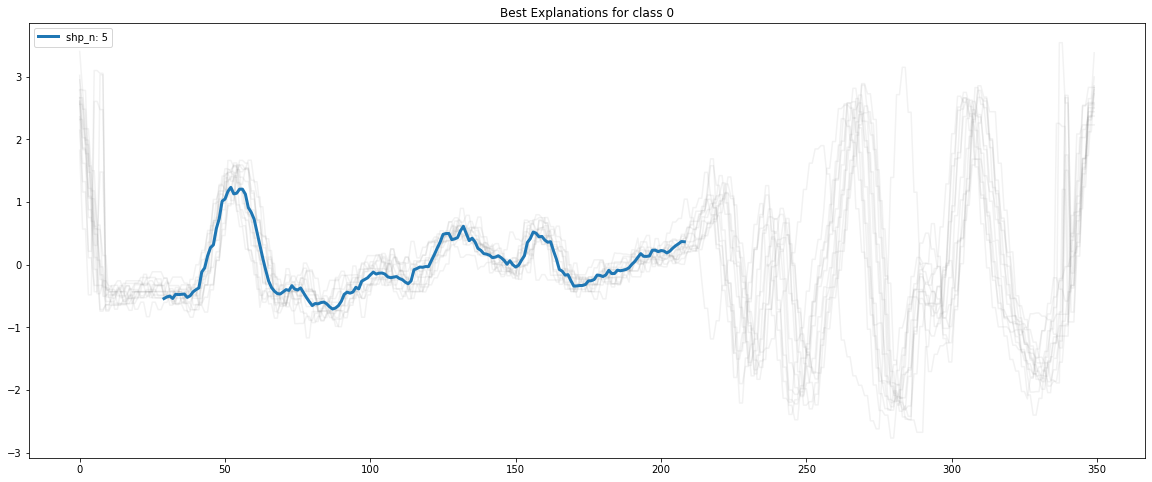

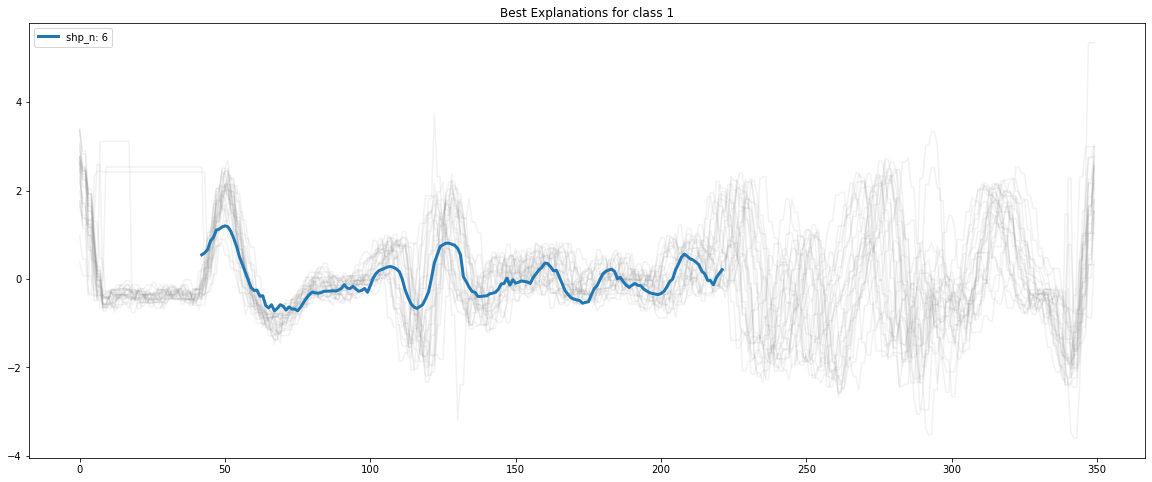

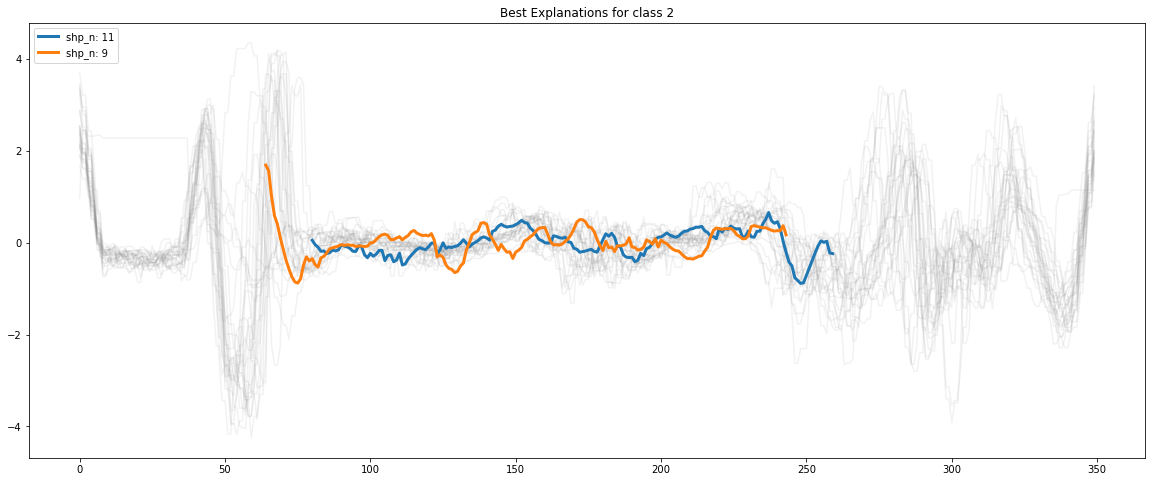

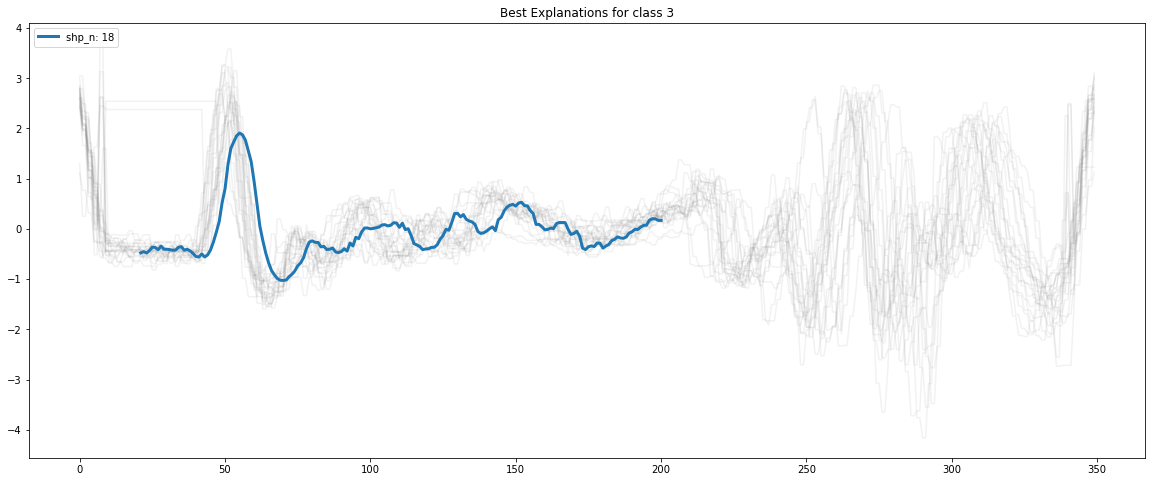

In [428]:
def plot_class_and_shapelets_2(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
        
    for sp in shp: 

        shp_n = sp
        shp_n = shapelets_Lr[shp_n]
        shp_n = filterNanFromShapelet(shp_n)
    
        shp_pos_n = np.array([torch_dist_ts_shapelet(X_test[ts],  shp_n, to_cuda=False)[1] for  ts in ts_per_class]).mean()
        shp_pos_n = int(np.round(shp_pos_n))
        padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
        pyplot.plot(padded_shapelet, label=f"shp_n: {sp}", linewidth=3)
        plt.legend(loc="upper left")
    pyplot.show()
    
yclass_n = 2
exp_per_ts = 1

#t0 = find_ts_per_class(y_test, 0)
#plot_class_and_shapelets_2(0, t0, X_test,[5, 14])

def plot_shapelets_for_classes(yclasses,bestExp):
    for yclass_n,exp in zip(yclasses,bestExp): 
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets_2(yclass_n, cl, X_test,exp)
        

#badEx = [[16, 1],[16, 1],[16, 1],[16, 1]]
#beEx = [[5, 14], [6, 13], [11, 9], [18, 2]]
beEx_train_test= [[5], [6], [11, 9], [18]]
plot_shapelets_for_classes(set(y_test), beEx_train_test)

IndexError: index 20 is out of bounds for axis 0 with size 20

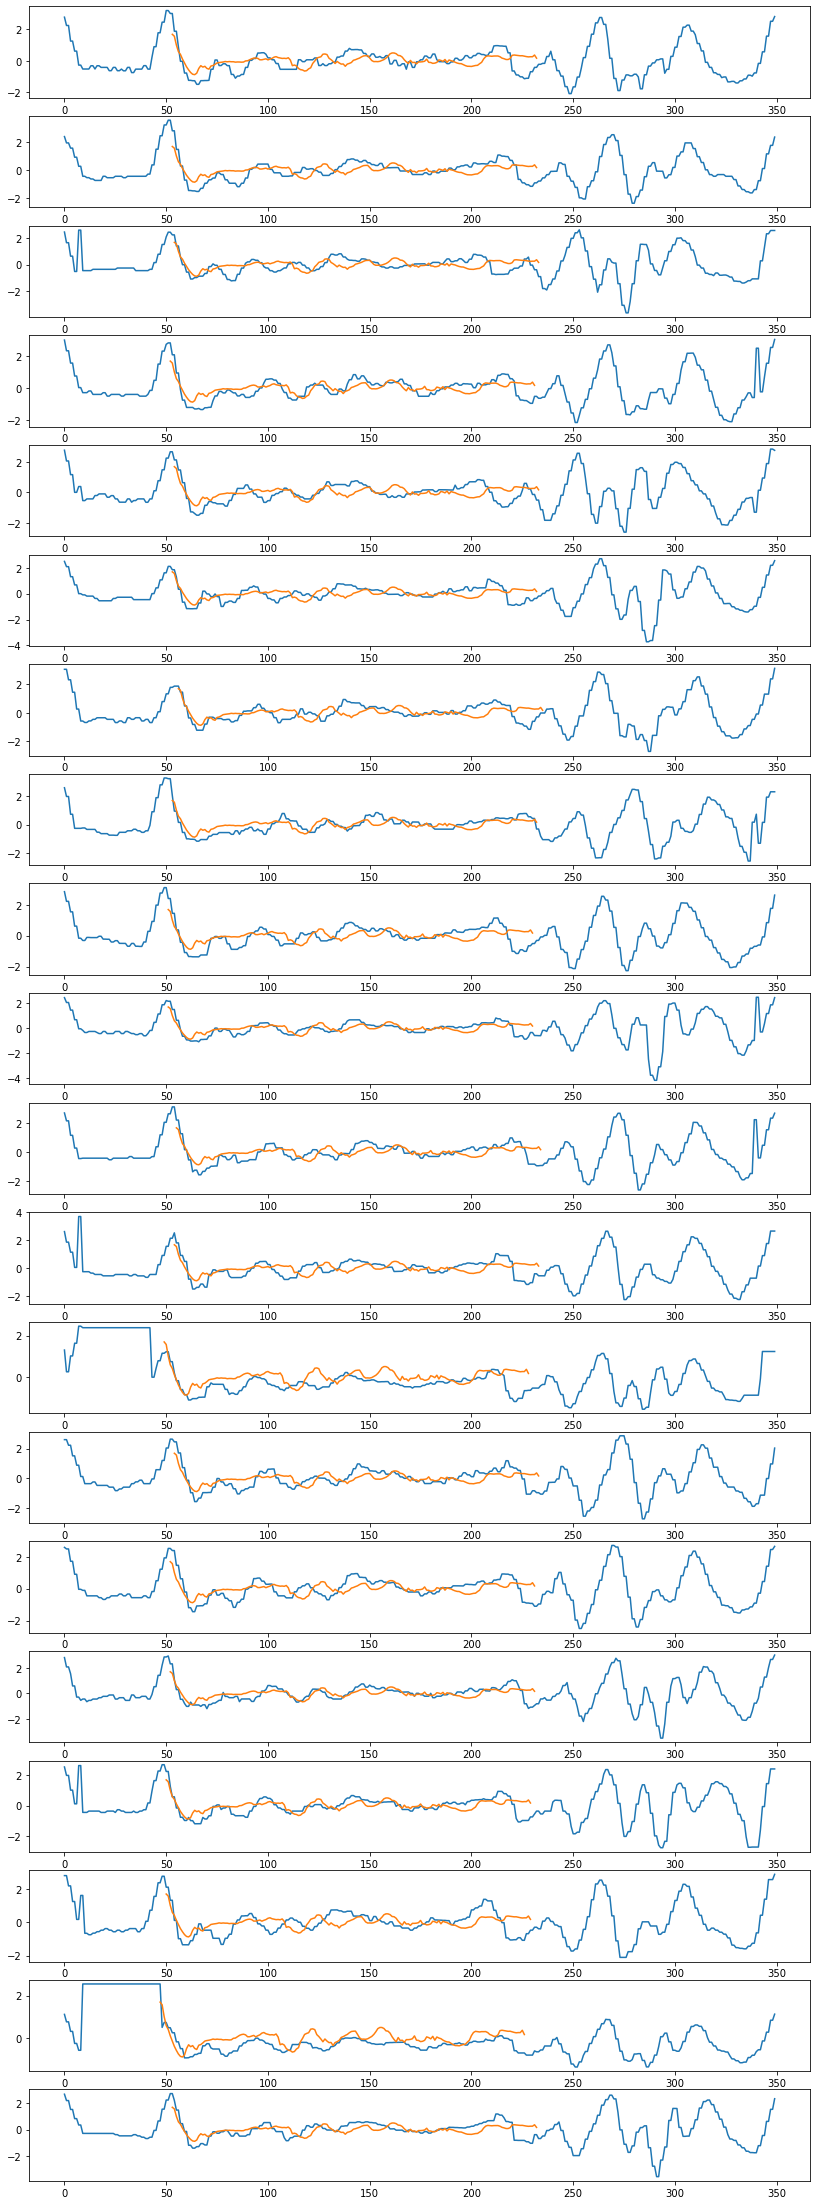

In [453]:
#[22], [25], [18, 28], [9, 1, 15, 16]]
ts_class = find_ts_per_class(y_test,3)
distances = dists_to_shapelet(X_test[ts_class],shapelets_Lr[9], to_cuda=False)
my_shapelet = filterNanFromShapelet(shapelets_Lr[9, 0])

#for ts in ts_class:
#print(torch_dist_ts_shapelet(X_test[ts],  my_shapelet, to_cuda=False))


fig, axes = pyplot.subplots(n_shapelets, 1)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
#fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

shapelet_Lr = ""#filterNanFromShapelet(shapelets_Lr[8, 0])
for i,ts in enumerate(ts_class):
    pos = torch_dist_ts_shapelet(X_test[ts],  my_shapelet, to_cuda=False)[1]
    #print(shapelet_Lr, X_test[ts])
    plot_shapelet_on_ts_at_i(my_shapelet, X_test[ts,0],pos, axis=axes[i])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()





(180,)

[51 52  2 79 67 77 31 65 63 27 86 40 24 45 22 21  8 59 18 60 16 15 72 13
 12 76]
122
180 180
[0]
Accuracy: 0.0
350


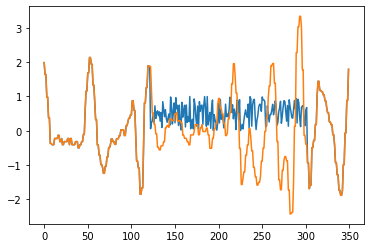

In [273]:
#[[8, 3], [6, 0], [13], [9]]
#[[5, 14], [6, 13], [11, 9], [18, 2]]
import matplotlib.pyplot as plt
print(find_ts_per_class(y_test,1))
my_shapelet = filterNanFromShapelet(shapelets_Lr[13, 0])
counter_shapelet = filterNanFromShapelet(shapelets_Lr[13, 0])
pos = torch_dist_ts_shapelet(X_test[51],  my_shapelet, to_cuda=False)[1]
print(pos)
posidx = [i for i in range(pos,pos+len(my_shapelet))]
print(len(posidx), len(my_shapelet))
#print(ts_class,X_train.shape,np.array(y_train[0]))
#eval_accuracy(learning_shapelets_Lr, X_train[0], y_train[0])

d = X_test[51].copy()


xmod = d

#zero shapelet
zero_shapelet = np.zeros(180)
rand_shapelet = np.random.rand(180)
#np.put(xmod, posidx, counter_shapelet)
np.put(xmod, posidx, rand_shapelet)


#print(xmod == X_test[52])


xt1 = np.expand_dims(np.array(xmod), axis=0)
yt1 = np.expand_dims(np.array(y_test[51]), axis=0)

eval_accuracy(learning_shapelets_Lr, xt1, yt1)


plt.plot(xmod.T)
plt.plot(X_test[51].T)
print(len(X_test[51].T))
#plt.plot(counter_shapelet)

In [421]:
import matplotlib.pyplot as plt
import math
def validate_explanations_for_class(X_test, y_test, y_class, possible_exp, model):
    """
    exp_arr = array with explanations for each class
    """
    def flipped_pred(shapelet,posidx,ts):
        
        xmod = ts.copy()
        pos = [i for i in range(posidx,posidx+len(shapelet))]
        np.put(xmod, pos, shapelet)
        xmod = np.expand_dims(np.array(xmod), axis=0)
        
        """
        plt.plot(np.squeeze(xmod))
        padded_shapelet = lead_pad_shapelet(shapelet,posidx)
        plt.plot(padded_shapelet)
        
        """
        
        predictions = model.predict(xmod)
        if len(predictions.shape) == 2:
            predictions = predictions.argmax(axis=1)
        return int(predictions) != y_class, int(predictions)
        
    tss = find_ts_per_class(y_test,y_class)
    ts_exp = []
    for ts in tss:
        min_dis = math.inf
        best_pos = None
        best_exp = None
        for exp in possible_exp: 
            shapelet = filterNanFromShapelet(shapelets_Lr[exp, 0])
            dis,pos = torch_dist_ts_shapelet(X_test[ts], shapelet, to_cuda=False)
            if dis < min_dis: 
                min_dis = dis
                best_exp = exp
                best_pos = pos
                
        ts = X_test[ts]
        
        #Insert shapelets into zero vector
        #zero_vec = np.expand_dims(np.random.randn(len(ts.flatten())), axis=0)
        zero_vec = np.expand_dims(np.zeros(len(ts.flatten())), axis=0)
        pos_rand = np.random.randint(0,170)
        pseudo_flipped, pred = flipped_pred(shapelet,pos_rand,zero_vec)
        
        
        #Occlude with zeros
        #print(ts.shape)
        zero_shapelet = np.zeros(len(shapelet))
        zero_flipped, zflipped_to = flipped_pred(zero_shapelet,best_pos,ts)
        
        #Occlude with random noise
        rand_shapelet = np.random.rand(len(shapelet))
        rand_flipped, rflipped_to = flipped_pred(rand_shapelet,best_pos,ts)
        

        ts_exp.append([ts,best_exp,best_pos,zero_flipped,zflipped_to,rand_flipped,rflipped_to,pred])
    return ts_exp


columns=["TimeSeries","Shapelet Explanation", "Pos", "Zero Flip", "Flip to", "Rand Flip", "Flip to", "Shap in Zero Vec"]
exp_class_0 = validate_explanations_for_class(X_test,y_test,0,[5,14],learning_shapelets_Lr)
exp_class_1 = validate_explanations_for_class(X_test,y_test,1,[6,13],learning_shapelets_Lr)
exp_class_2 = validate_explanations_for_class(X_test,y_test,2,[11,9],learning_shapelets_Lr)
exp_class_3 = validate_explanations_for_class(X_test,y_test,3,[18,2],learning_shapelets_Lr)

pd.DataFrame(exp_class_3,columns=columns)

,TimeSeries,Shapelet Explanation,Pos,Zero Flip,Flip to,Rand Flip,Flip to,Shap in Zero Vec
0,"[[2.7834857000000004, 2.2542758999999997, 2.25...",18,16,False,3,False,3,1
1,"[[2.4039772, 1.9481023000000002, 1.94810230000...",2,74,True,2,False,3,1
2,"[[2.4699527999999997, 1.6627147, 1.6627147, 0....",18,17,True,2,True,2,1
3,"[[3.0079658, 2.3370676, 2.3370676, 1.5665401, ...",18,16,True,2,False,3,1
4,"[[2.7703203999999997, 2.0628406999999997, 2.06...",18,18,True,2,True,2,1
5,"[[2.5012362, 2.0940073, 2.0940073, 1.315957, 1...",2,69,True,2,True,0,1
6,"[[3.043848, 3.043848, 2.3091867, 2.3091867, 1....",18,19,True,2,False,3,1
7,"[[2.5851021, 1.972539, 1.972539, 0.72535584, 0...",2,84,True,2,True,0,1
8,"[[2.8494829, 2.2224671000000003, 2.22246710000...",18,15,True,2,False,3,1
9,"[[2.4382366, 2.0515973, 2.0515973, 1.4428193, ...",18,16,True,2,True,2,1
